# Cars

## Support code

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import tsensor

In [2]:
def carshow(m, b, X, y, file=None):
    fig, ax = plt.subplots(figsize=(4,3))

    ax.scatter(X, y, s=15, color='#F46C43', alpha=.5)
    ax.plot(X, m * X + b, lw=.5, color='black')
    ax.set_title(f"$y = {m:.3f}x + {b:.2f}$")
    if sum(X)/len(X)<1.0:
        ax.set_xlabel("Weight (Standardized)")
    else:
        ax.set_xlabel("Weight")
    ax.set_ylabel("MPG")

    if file:
        plt.savefig(f"/Users/parrt/Desktop/{file}.pdf")
    
    plt.show()

def mshow(model, X, y, file=None):
    fig, ax = plt.subplots(figsize=(4,3))

    with torch.no_grad():
        y_pred = model(X)
    ax.scatter(X, y, s=15, color='#F46C43', alpha=.5)
    ax.scatter(X, y_pred, lw=.5, color='black', s=1)
    if sum(X)/len(X)<1.0:
        ax.set_xlabel("Weight (Standardized)")
    else:
        ax.set_xlabel("Weight")
    ax.set_ylabel("MPG")
    plt.tight_layout()
    if file:
        plt.savefig(f"/Users/parrt/Desktop/{file}.pdf")
    plt.show()

## Load simple data set

In [3]:
df_cars = pd.read_csv("../data/cars.csv")
df_cars.head(2)

,MPG,CYL,ENG,WGT
0,18.0,8,307.0,3504
1,15.0,8,350.0,3693


In [4]:
n = len(df_cars)
X = torch.tensor(df_cars.WGT).float().reshape(n,1)
X = (X-torch.mean(X))/torch.std(X)
y = torch.tensor(df_cars.MPG).reshape(n,1)

## Pytorch built-in linear model

Epoch   0 MSE loss      644.606 MAE    24.38
Epoch  10 MSE loss      234.723 MAE    14.56
Epoch  20 MSE loss       54.683 MAE     6.17
Epoch  30 MSE loss       19.162 MAE     3.27
Epoch  40 MSE loss       23.638 MAE     3.94
Epoch  50 MSE loss       22.148 MAE     3.80
Epoch  60 MSE loss       19.047 MAE     3.37
Epoch  70 MSE loss       18.742 MAE     3.27
LAST      MSE loss       18.742 MAE     3.27


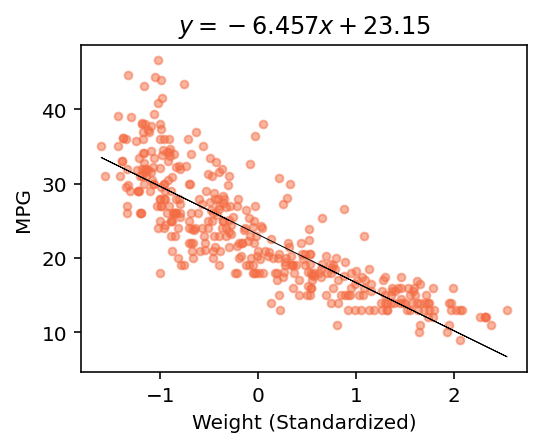

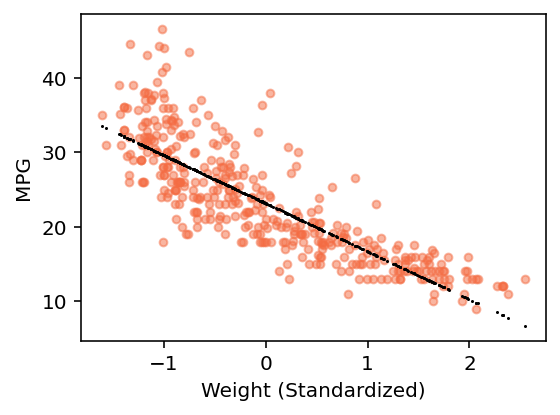

In [5]:
model = nn.Linear(1, 1) # each instance has 1 value, spit out 1 value

learning_rate = 1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
nepochs=70
for epoch in range(nepochs+1):
    with tsensor.clarify():
        y_pred = model(X)
    loss = torch.mean((y_pred - y)**2)
    if epoch % 10 == 0:
        with torch.no_grad():
            mae = torch.mean(torch.abs(y_pred - y))
            print(f"Epoch {epoch:3d} MSE loss {loss:12.3f} MAE {mae:8.2f}")

    # Backprop to compute gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step() # adjust weights
    
m = model.weight.detach().item()
b = model.bias.detach().item()
print(f"LAST      MSE loss {loss:12.3f} MAE {mae:8.2f}")

carshow(m, b, X=X, y=df_cars.MPG)
mshow(model, X=X, y=df_cars.MPG)

## Factor out a training method

In [6]:
def train(model, learning_rate = .5, nepochs=2000):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(nepochs+1):
        y_pred = model(X)
        loss = torch.mean((y_pred - y)**2)
        if epoch % (nepochs//10) == 0:
            with torch.no_grad():
                mae = torch.mean(torch.abs(y_pred - y))
                print(f"Epoch {epoch:4d} MSE loss {loss:12.3f} MAE {mae:8.2f}")

        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()
    print(f"LAST       MSE loss {loss:12.3f} MAE {mae:8.2f}")
    return loss

Epoch    0 MSE loss      622.116 MAE    23.45
Epoch    7 MSE loss      292.007 MAE    16.52
Epoch   14 MSE loss      124.809 MAE    10.05
Epoch   21 MSE loss       39.914 MAE     5.06
Epoch   28 MSE loss       19.536 MAE     3.26
Epoch   35 MSE loss       22.483 MAE     3.85
Epoch   42 MSE loss       24.229 MAE     4.02
Epoch   49 MSE loss       22.166 MAE     3.78
Epoch   56 MSE loss       19.461 MAE     3.43
Epoch   63 MSE loss       18.723 MAE     3.27
Epoch   70 MSE loss       18.824 MAE     3.28
LAST       MSE loss       18.824 MAE     3.28


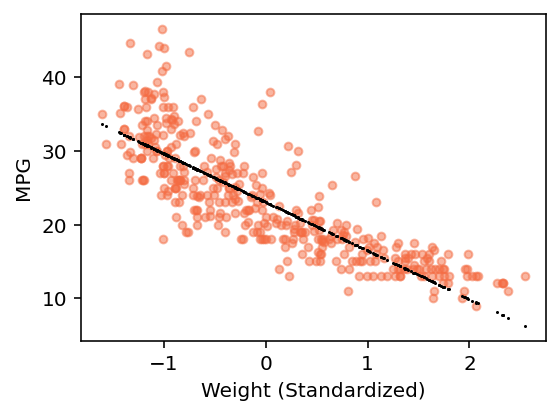

In [7]:
model = nn.Linear(1, 1)

train(model, learning_rate=1, nepochs=70)

mshow(model, X=X, y=df_cars.MPG)

## Sequence of 2 linear models with pytorch

Unless we add relu or sigmoid, 2 models chained is same as one: it's a line.

Let's create a generic training function for given model and a new show function.

### Without nonlinearity

Epoch    0 MSE loss      639.875 MAE    24.17
Epoch   10 MSE loss       59.829 MAE     6.51
Epoch   20 MSE loss       65.732 MAE     7.30
Epoch   30 MSE loss       23.293 MAE     3.92
Epoch   40 MSE loss       26.039 MAE     3.65
Epoch   50 MSE loss       19.761 MAE     3.49
Epoch   60 MSE loss       19.070 MAE     3.38
Epoch   70 MSE loss       19.106 MAE     3.26
Epoch   80 MSE loss       18.758 MAE     3.31
Epoch   90 MSE loss       18.678 MAE     3.28
Epoch  100 MSE loss       18.679 MAE     3.28
LAST       MSE loss       18.679 MAE     3.28


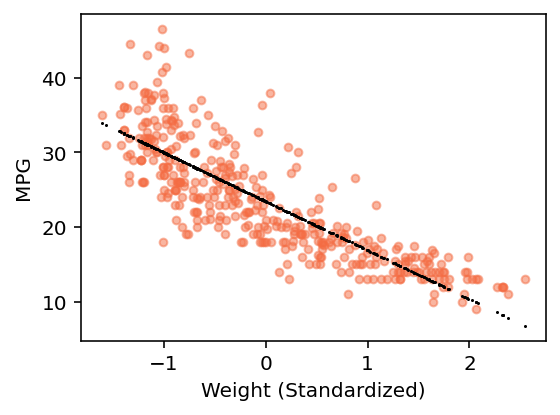

In [8]:
model = nn.Sequential(
    nn.Linear(1, 1), # each instance has 1 value, spit out 1 values
    nn.Linear(1, 1)
)

train(model, learning_rate=2.1, nepochs=100)

mshow(model, X=X, y=df_cars.MPG, file="2linear")

### With ReLU nonlinearity

Epoch    0 MSE loss      634.509 MAE    23.93
Epoch   10 MSE loss       33.079 MAE     4.95
Epoch   20 MSE loss       18.466 MAE     3.31
Epoch   30 MSE loss       18.423 MAE     3.17
Epoch   40 MSE loss       17.954 MAE     3.13
Epoch   50 MSE loss       17.862 MAE     3.17
Epoch   60 MSE loss       17.818 MAE     3.14
Epoch   70 MSE loss       17.835 MAE     3.13
Epoch   80 MSE loss       17.804 MAE     3.16
Epoch   90 MSE loss       17.783 MAE     3.14
Epoch  100 MSE loss       17.774 MAE     3.13
LAST       MSE loss       17.774 MAE     3.13


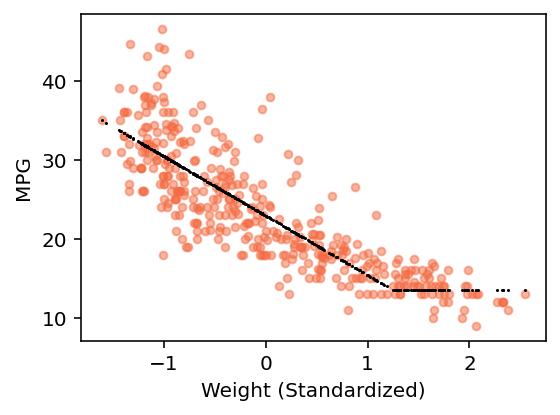

In [9]:
model = nn.Sequential(
    nn.Linear(1, 1), # each instance has 1 value, spit out 1 values
    nn.ReLU(),     # add nonlinearity, gives two lines
    nn.Linear(1, 1)
)

train(model, learning_rate=1, nepochs=100)

mshow(model, X=X, y=df_cars.MPG, file="linRlin")

Epoch    0 MSE loss      622.695 MAE    23.68
Epoch   10 MSE loss       44.746 MAE     4.92
Epoch   20 MSE loss       36.549 MAE     4.50
Epoch   30 MSE loss       23.729 MAE     3.37
Epoch   40 MSE loss       18.429 MAE     3.08
Epoch   50 MSE loss       17.569 MAE     3.06
Epoch   60 MSE loss       17.411 MAE     3.04
Epoch   70 MSE loss       17.403 MAE     3.03
Epoch   80 MSE loss       17.386 MAE     3.03
Epoch   90 MSE loss       17.344 MAE     3.04
Epoch  100 MSE loss       17.325 MAE     3.04
LAST       MSE loss       17.325 MAE     3.04


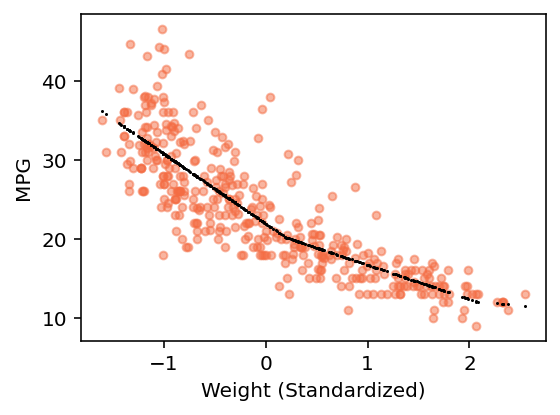

In [10]:
model = nn.Sequential(
    nn.Linear(1, 5),
    nn.ReLU(),
    nn.Linear(5, 1)
)

train(model, learning_rate=1, nepochs=100)

mshow(model, X=X, y=df_cars.MPG, file="lin5Rlin")

Epoch    0 MSE loss      590.217 MAE    23.02
Epoch   10 MSE loss      320.079 MAE    16.78
Epoch   20 MSE loss       44.793 MAE     5.67
Epoch   30 MSE loss       18.944 MAE     3.32
Epoch   40 MSE loss       26.159 MAE     3.76
Epoch   50 MSE loss       21.466 MAE     3.68
Epoch   60 MSE loss       18.136 MAE     3.08
Epoch   70 MSE loss       17.558 MAE     3.12
Epoch   80 MSE loss       17.565 MAE     3.12
Epoch   90 MSE loss       17.556 MAE     3.08
Epoch  100 MSE loss       17.524 MAE     3.11
LAST       MSE loss       17.524 MAE     3.11


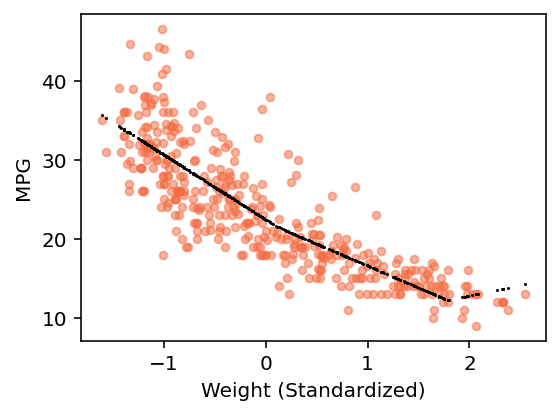

In [11]:
model = nn.Sequential(
    nn.Linear(1, 5),
    nn.ReLU(),
    nn.Linear(5, 2),
    nn.ReLU(),
    nn.Linear(2, 1)
)

train(model, learning_rate=.1, nepochs=100)

mshow(model, X=X, y=df_cars.MPG, file="lin5Rlin2")

### What matrix algebra is that model doing?

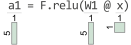

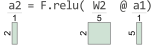

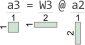

In [12]:
# Draw matrix shapes
import torch.nn.functional as F
import tsensor

W1 = torch.rand(5,1)
W2 = torch.rand(2,5)
W3 = torch.rand(1,2)
x = torch.rand(1,1)
with tsensor.explain() as e:
    a1 = F.relu(W1 @ x)
    a2 = F.relu(W2 @ a1)
    a3 = W3 @ a2

### With logistic function (sigmoid) nonlinearity

Epoch    0 MSE loss      562.253 MAE    22.41
Epoch   10 MSE loss      888.569 MAE    29.08
Epoch   20 MSE loss      262.680 MAE    14.14
Epoch   30 MSE loss       36.947 MAE     4.90
Epoch   40 MSE loss       62.603 MAE     6.14
Epoch   50 MSE loss       51.146 MAE     5.49
Epoch   60 MSE loss       40.335 MAE     4.93
Epoch   70 MSE loss       36.267 MAE     4.68
Epoch   80 MSE loss       34.715 MAE     4.65
Epoch   90 MSE loss       33.917 MAE     4.62
Epoch  100 MSE loss       33.764 MAE     4.66
LAST       MSE loss       33.764 MAE     4.66


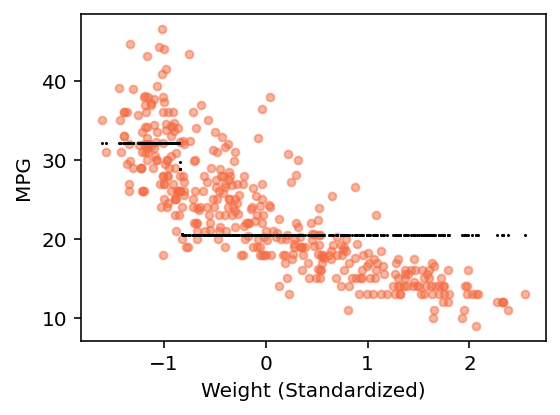

In [13]:
model = nn.Sequential(
    nn.Linear(1, 1), # each instance has 1 value, spit out 1 values
    nn.Sigmoid(),    # doesn't converge as fast; bump learning rate
    nn.Linear(1, 1)
)

train(model, learning_rate=50, nepochs=100)

mshow(model, X=X, y=df_cars.MPG, file='linSlin')

## Overfitting with a two-layer pytorch network

Epoch    0 MSE loss      631.046 MAE    23.89
Epoch  200 MSE loss       17.132 MAE     3.04
Epoch  400 MSE loss       16.939 MAE     3.03
Epoch  600 MSE loss       16.723 MAE     3.02
Epoch  800 MSE loss       16.601 MAE     3.01
Epoch 1000 MSE loss       16.561 MAE     2.99
Epoch 1200 MSE loss       16.610 MAE     2.97
Epoch 1400 MSE loss       16.539 MAE     2.98
Epoch 1600 MSE loss       16.654 MAE     3.03
Epoch 1800 MSE loss       16.642 MAE     3.03
Epoch 2000 MSE loss       16.505 MAE     2.98
LAST       MSE loss       16.505 MAE     2.98


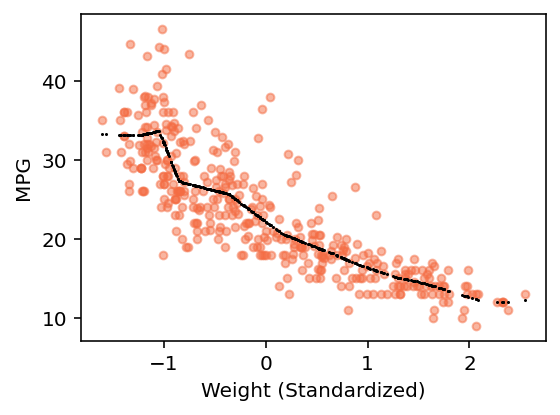

In [14]:
model = nn.Sequential(
    nn.Linear(1, 1000), # each instance has 1 value, spit out 1000 values
    nn.ReLU(),          # fast to compute, not smooth y_pred
    nn.Linear(1000, 1)
)

train(model, learning_rate=.1)

mshow(model, X=X, y=df_cars.MPG, file="lin1kRlin")

Epoch    0 MSE loss      589.599 MAE    22.93
Epoch  150 MSE loss       17.308 MAE     3.05
Epoch  300 MSE loss       17.301 MAE     3.05
Epoch  450 MSE loss       17.250 MAE     3.05
Epoch  600 MSE loss       17.483 MAE     3.03
Epoch  750 MSE loss       17.068 MAE     3.02
Epoch  900 MSE loss       16.983 MAE     3.01
Epoch 1050 MSE loss       16.911 MAE     3.00
Epoch 1200 MSE loss       16.844 MAE     3.00
Epoch 1350 MSE loss       16.788 MAE     3.00
Epoch 1500 MSE loss       16.755 MAE     2.99
LAST       MSE loss       16.755 MAE     2.99


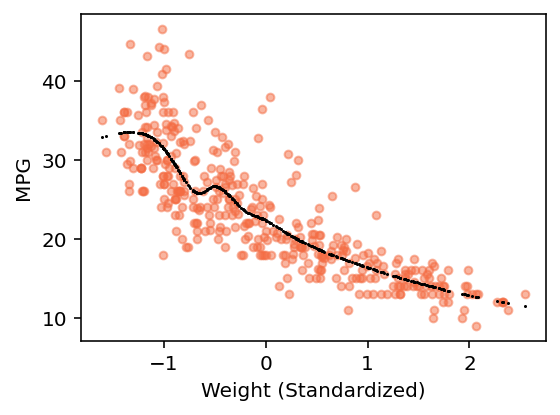

In [15]:
model = nn.Sequential(
    nn.Linear(1, 1000), # each instance has 1 value, spit out 1000 values
    nn.Tanh(),          # add nonlinearity
    nn.Linear(1000, 1)
)

train(model, learning_rate=.1, nepochs=1500)

mshow(model, X=X, y=df_cars.MPG)